In [17]:
#Classify space rocks using AI model 

In [42]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
import torch 
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F


In [20]:
import torchvision
from torchvision import datasets, transforms, models 

In [21]:
from PIL import Image

In [22]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [28]:
data_dir = 'C:/users/verys/Downloads/Data'

def load_split_train_test(data_dir, valid_size ):

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()
    ])

    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()

    ])

    train_data  = datasets.ImageFolder (data_dir, transform = train_transforms)
    test_data  = datasets.ImageFolder (data_dir, transform = test_transforms)
    
    num_train = len(train_data) 

    indices = list(range(num_train))
    
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = 16)
    testloader = torch.utils.data.DataLoader(test_data, sampler = test_sampler, batch_size = 16)

    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .3)

print(trainloader.dataset.classes)

['Basalt', 'Highland']


In [40]:
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                   transforms.Resize(224),
                                   transforms.ToTensor(),
                                 ])
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    dataiter = iter(loader)

    images, labels = next(dataiter)
    return images, labels

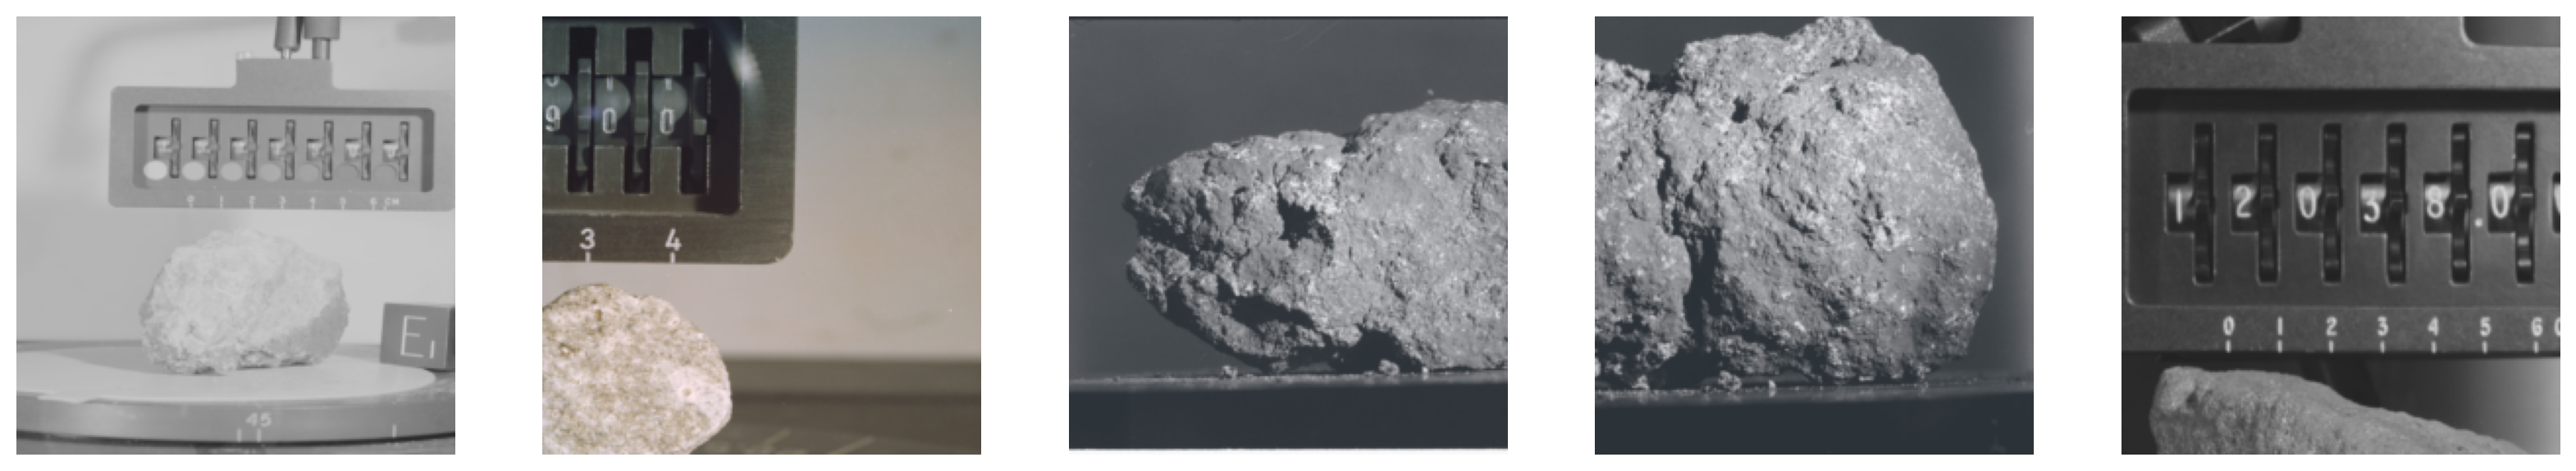

In [46]:

images, labels = get_random_images(5)

to_pil = transforms.ToPILImage()
fig=plt.figure(figsize=(20,20))

classes=trainloader.dataset.classes

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)

plt.show()

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained= True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048,512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512,2),
                         nn.LogSoftmax(dim=1))


criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.003)

model.to(device)
print('neural network build complete')

neural network build complete


In [56]:
epochs =5 
print_every =5

running_loss = 0
train_losses, test_losses = [], []

steps = 0

for epoch in range(epochs):

    epochs +=1

    for inputs, labels in trainloader:

        steps +=1
        print('Training step', steps)
        input, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        
        if steps % print_every ==0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():

                for inputs, labels in testloader:

                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                print(f"\n      Epoch {epoch}/{epochs}: "
                      f"Train loss {running_loss/print_every: 3f}.. "
                      f"Test loss {test_loss/len(testloader): 3f}.. "
                      f"Test accuracy {accuracy/len(testloader): 3f}\n.. "
                        )
                running_loss = 0
                model.train()

                break



Training step 1
Training step 2
Training step 3
Training step 4
Training step 5

      Epoch 0/6: Train loss  0.415659.. Test loss  0.536322.. Test accuracy  0.696429
.. 
Training step 6
Training step 7
Training step 8
Training step 9
Training step 10

      Epoch 1/7: Train loss  0.409546.. Test loss  0.381908.. Test accuracy  0.827381
.. 
Training step 11
Training step 12
Training step 13
Training step 14
Training step 15

      Epoch 2/8: Train loss  0.382202.. Test loss  0.339683.. Test accuracy  0.869048
.. 
Training step 16
Training step 17
Training step 18
Training step 19
Training step 20

      Epoch 3/9: Train loss  0.317815.. Test loss  0.238890.. Test accuracy  0.934524
.. 
Training step 21
Training step 22
Training step 23
Training step 24
Training step 25

      Epoch 4/10: Train loss  0.299759.. Test loss  0.353332.. Test accuracy  0.869048
.. 


In [57]:
print (accuracy/len(testloader))


0.8690476218859354


In [58]:
torch.save(model, 'aerialmodel.pth')

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')

In [60]:
def predict_image(image):
        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        input = input.to(device)
        output = model(input)
        index = output.data.cpu().numpy().argmax()
        return index

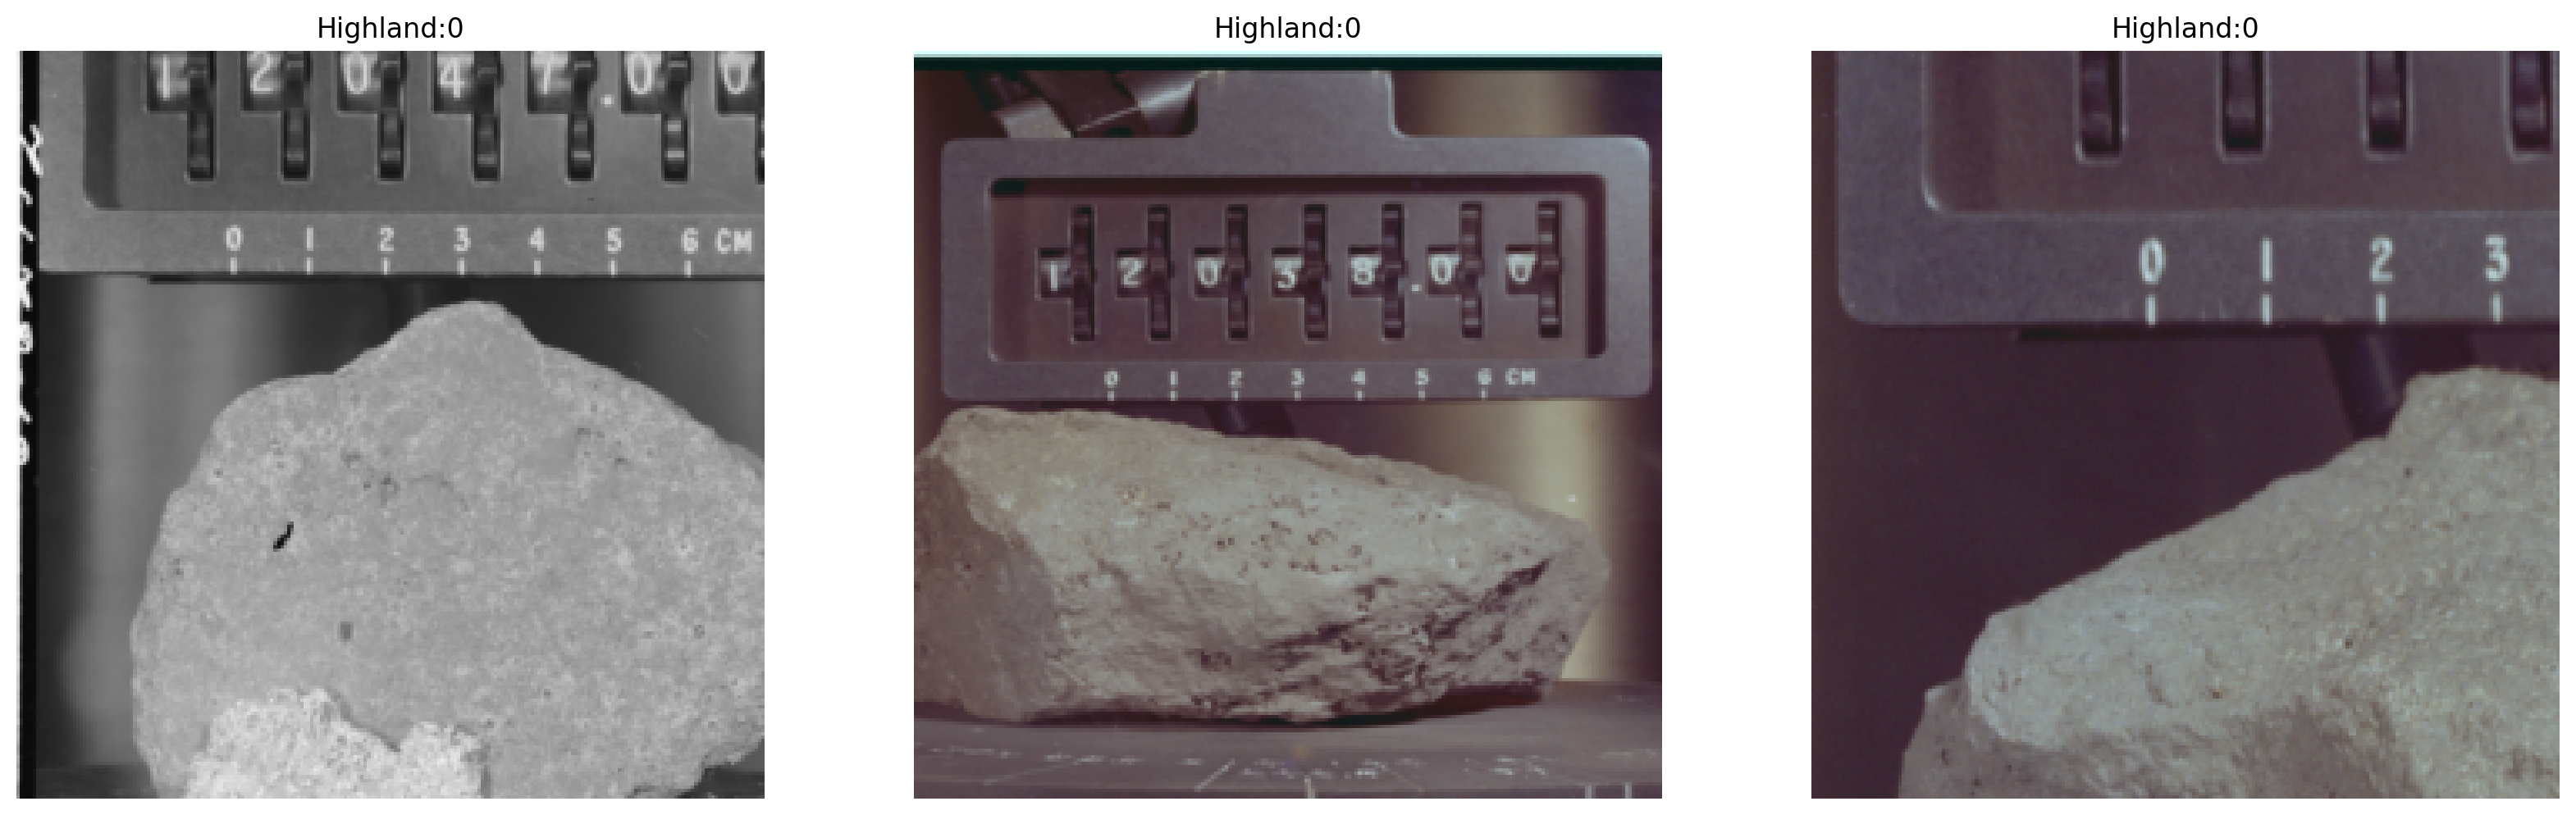

In [65]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(3)
fig=plt.figure(figsize=(20,10))

classes=trainloader.dataset.classes

for i in range(len(images)):

    image = to_pil(images[i])
    index = predict_image(image)

    sub = fig.add_subplot(1, len(images), i+1)
    res = int(labels[i] == index)
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)

plt.show()